# **Vision Transformer**
### Sebastián Novoa Acevedo

### **Referencias**
- https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb#scrollTo=TSAVpYtP5VaE

### Configuraciones

### **Se debe cambiar el entorno de ejecución para acelerar por hardware a la opción de TPU**

In [1]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 49 (delta 6), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (49/49), done.
Already up to date.


In [2]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 92 kB 898 kB/s 
     |████████████████████████████████| 41 kB 467 kB/s 
     |████████████████████████████████| 189 kB 53.1 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
     |████████████████████████████████| 221.4 MB 56 kB/s 
     |████████████████████████████████| 5.8 MB 56.5 MB/s 
     |████████████████████████████████| 349 kB 81.7 MB/s 
     |████████████████████████████████| 154 kB 79.6 MB/s 
     |████████████████████████████████| 8.3 MB 73.9 MB/s 
     |████████████████████████████████| 237 kB 82.1 MB/s 
     |████████████████████████████████| 6.0 MB 53.2 MB/s 
     |████████████████████████████████| 439 kB 74.4 MB/s 
     |████████████████████████████████| 1.7 MB 55.6 MB/s 
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 


### Importamos modelos pre-entrenados

In [3]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

### Descargamos un modelo pre-entrenado (en este caso ViT-B_32)

In [4]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
\ [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


### Importamos archivos

In [5]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [6]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
# from google.colab import files
# files.view('vision_transformer/vit_jax/configs/common.py')
# files.view('vision_transformer/vit_jax/configs/models.py')
# files.view('vision_transformer/vit_jax/checkpoint.py')
# files.view('vision_transformer/vit_jax/input_pipeline.py')
# files.view('vision_transformer/vit_jax/models.py')
# files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

### Etiquetas para las imágenes a procesar

In [8]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Cargamos el dataset (cifar10)

In [9]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
config.batch = batch_size
config.pp.crop = 224

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpaqs5aic8tfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.


### Definimos Train y Test, para el entrenamiento y evaluación del modelo

In [10]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')

del config  # Only needed to instantiate datasets.

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpjxfy1tnbtfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (~/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.e58922d4f4b64cc5b6cb8a2c43df46ba...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteUA1URP/cifar10-train.tfrecord*...:   0%|          | 0/…

INFO:absl:Done writing ~/tensorflow_datasets/cifar10/3.0.2.incompleteUA1URP/cifar10-train.tfrecord*. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteUA1URP/cifar10-test.tfrecord*...:   0%|          | 0/1…

INFO:absl:Done writing ~/tensorflow_datasets/cifar10/3.0.2.incompleteUA1URP/cifar10-test.tfrecord*. Number of examples: 10000 (shards: [10000])
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from ~/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (~/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from ~/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2


### Dimensiones de una imagen

In [11]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 512, 224, 224, 3)

### Mostramos algunas imágenes con sus etiquetas

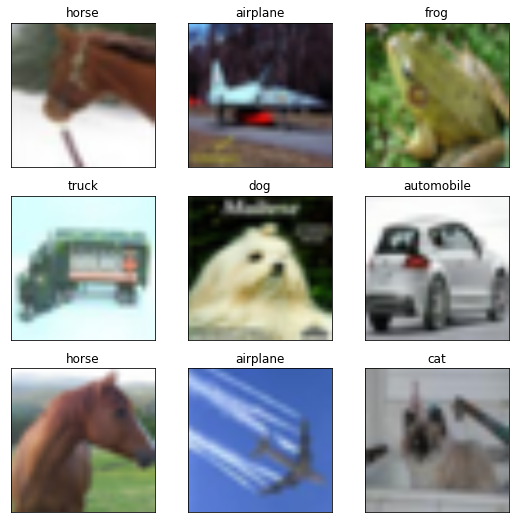

In [12]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Mostramos imágenes de entrenamiento

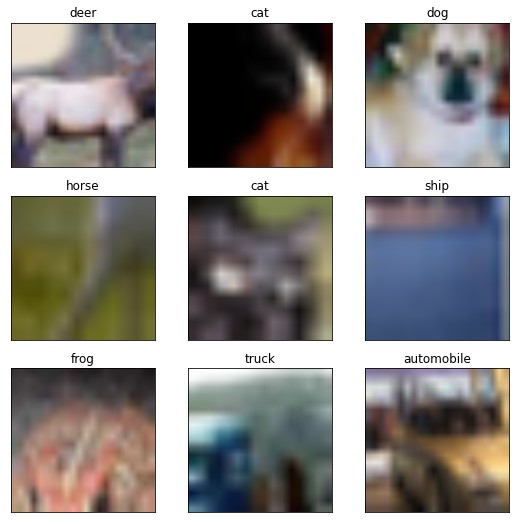

In [13]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Cargamos el modelo pre-entrenado anteriormente

In [14]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [15]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [16]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


### Evaluamos el modelo

In [17]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (10,)
params_repl.cls: ShardedDeviceArray (1, 10)


In [18]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

### Precisión del modelo

In [19]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [20]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


DeviceArray(0.10063734, dtype=float32)

Aproximadamente se demora 23 minutos en su ejecución sin TPU, con el entorno potenciado se demora aproximadamente 1 minuto

Es un 10.06% de precisión (bastante bajo)

### Ajustamos el modelo

In [21]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [22]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [23]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

### Graficamos las pérdidas del modelo

100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


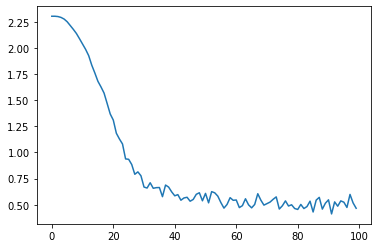

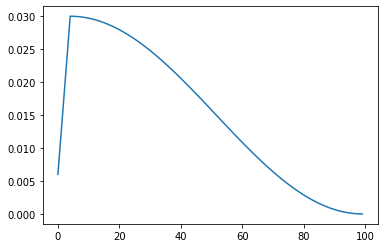

In [24]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

Aquí se requiere utilizar la aceleración por hardware TPU de todas maneras, ya que, tiene un tiempo de ejecución de aproximadamente 15 minutos, sin TPU tiene un tiempo estimado de 4 horas

### Precisión final

In [25]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:27<00:00,  1.47s/it]


DeviceArray(0.9771793, dtype=float32)

1 minuto de tiempo de ejecución

Obtenemos ahora un 97.65% de precisión, lo cual es bastante bueno

### Inferencia

In [26]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
/ [1 files][336.9 MiB/336.9 MiB]                                                
Operation completed over 1 objects/336.9 MiB.                                    


### Cargamos modelo pre-entrenado

In [27]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

### Obtenemos etiquetas

In [28]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2022-12-07 02:37:39--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-12-07 02:37:39 (91.9 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



### Obtenemos una imagen aleatoria con dimensiones específicas

# DEBEMOS RECALCAR QUE FUNCIONA CON IMÁGENES DE 384X384

### Imagen aleatoria

--2022-12-07 02:37:40--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 172.67.74.163, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/391/384/384.jpg?hmac=Ow5fsCfxYusocalOo7d8x3u6G01lUOvBCuTVuN2OCAc [following]
--2022-12-07 02:37:40--  https://i.picsum.photos/id/391/384/384.jpg?hmac=Ow5fsCfxYusocalOo7d8x3u6G01lUOvBCuTVuN2OCAc
Resolving i.picsum.photos (i.picsum.photos)... 172.67.74.163, 104.26.4.30, 104.26.5.30, ...
Connecting to i.picsum.photos (i.picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15668 (15K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]  15.30K  --.-KB/s    in 0.001s  

2022-12-07 02:37:40 (28.2 MB/s) - ‘picsum.jpg’ saved [15668/15668]



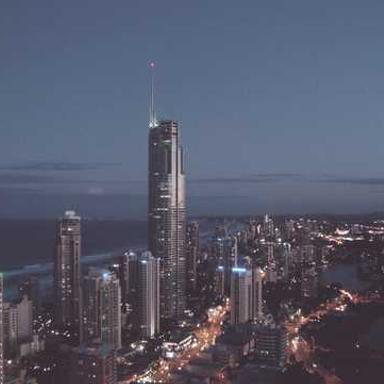

In [29]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

### Predecimos

In [30]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [31]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.35659 : seashore, coast, seacoast, sea-coast
0.24023 : lakeside, lakeshore
0.04692 : beacon, lighthouse, beacon_light, pharos
0.03930 : airship, dirigible
0.02583 : promontory, headland, head, foreland
0.01902 : bell_cote, bell_cot
0.01619 : drilling_platform, offshore_rig
0.01436 : breakwater, groin, groyne, mole, bulwark, seawall, jetty
0.01396 : balloon
0.01387 : pier


### Otra imagen

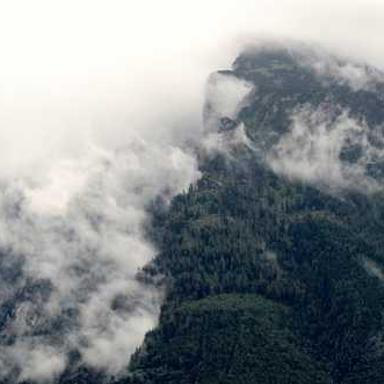

In [32]:
#Otra imagen con dimensiones 384x384
import PIL
img = PIL.Image.open('Paisaje.jpg')
img

### Predecimos

In [33]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [34]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.78921 : alp
0.08789 : volcano
0.08772 : valley, vale
0.01459 : cliff, drop, drop-off
0.00316 : lakeside, lakeshore
0.00208 : promontory, headland, head, foreland
0.00106 : ibex, Capra_ibex
0.00093 : geyser
0.00086 : dam, dike, dyke
0.00074 : mountain_tent


### Otra imagen

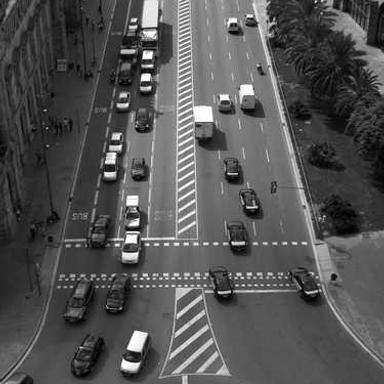

In [36]:
#Otra imagen con dimensiones 384x384
import PIL
img = PIL.Image.open('Ciudad.jpg')
img

### Predecimos

In [37]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [38]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.45453 : traffic_light, traffic_signal, stoplight
0.16501 : cab, hack, taxi, taxicab
0.06462 : street_sign
0.03292 : streetcar, tram, tramcar, trolley, trolley_car
0.01995 : trailer_truck, tractor_trailer, trucking_rig, rig, articulated_lorry, semi
0.01748 : trolleybus, trolley_coach, trackless_trolley
0.01385 : passenger_car, coach, carriage
0.01245 : limousine, limo
0.00859 : garbage_truck, dustcart
0.00602 : minibus


### Otra Imagen

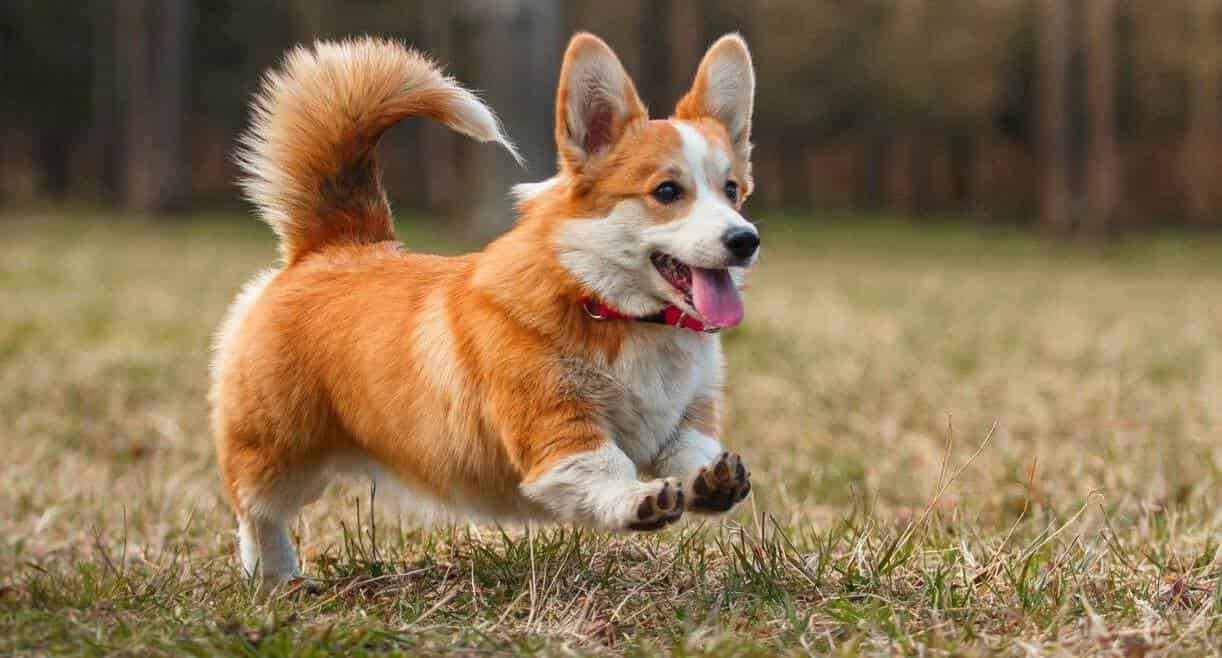

In [45]:
#Imagen con dimensiones cualquiera, pero debemos ajustar sus dimensiones a 384x384
import PIL
img = PIL.Image.open('Corgi.jpg')
img_384 = img.resize((384, 384))
img

### Predecimos

In [43]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img_384) / 128 - 1)[None, ...], train=False)

In [44]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.85525 : Pembroke, Pembroke_Welsh_corgi
0.14082 : Cardigan, Cardigan_Welsh_corgi
0.00028 : Chihuahua
0.00025 : basenji
0.00024 : beagle
0.00022 : collie
0.00019 : Ibizan_hound, Ibizan_Podenco
0.00018 : papillon
0.00016 : Border_collie
0.00012 : Shetland_sheepdog, Shetland_sheep_dog, Shetland


### Otra imagen

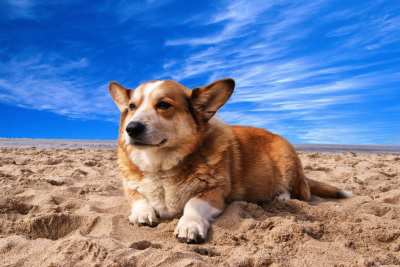

In [46]:
#Imagen con dimensiones cualquiera, pero debemos ajustar sus dimensiones a 384x384
import PIL
img = PIL.Image.open('Corgi2.jpg')
img_384 = img.resize((384, 384))
img

### Predecimos

In [47]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img_384) / 128 - 1)[None, ...], train=False)

In [48]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.48160 : Pembroke, Pembroke_Welsh_corgi
0.47969 : Cardigan, Cardigan_Welsh_corgi
0.01852 : dingo, warrigal, warragal, Canis_dingo
0.00478 : kelpie
0.00359 : German_shepherd, German_shepherd_dog, German_police_dog, alsatian
0.00111 : Border_collie
0.00090 : collie
0.00066 : basenji
0.00062 : Eskimo_dog, husky
0.00054 : Chihuahua


# Mapa de Atención

In [85]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from vision_transformer_pytorch import VisionTransformer

ModuleNotFoundError: ignored

In [68]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))


In [100]:
# Prepare Model

model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=384, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open("Corgi2.jpg")
x = transform(im)
x.size()


NameError: ignored

In [90]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

CallCompactUnboundModuleError: ignored

NameError: ignored

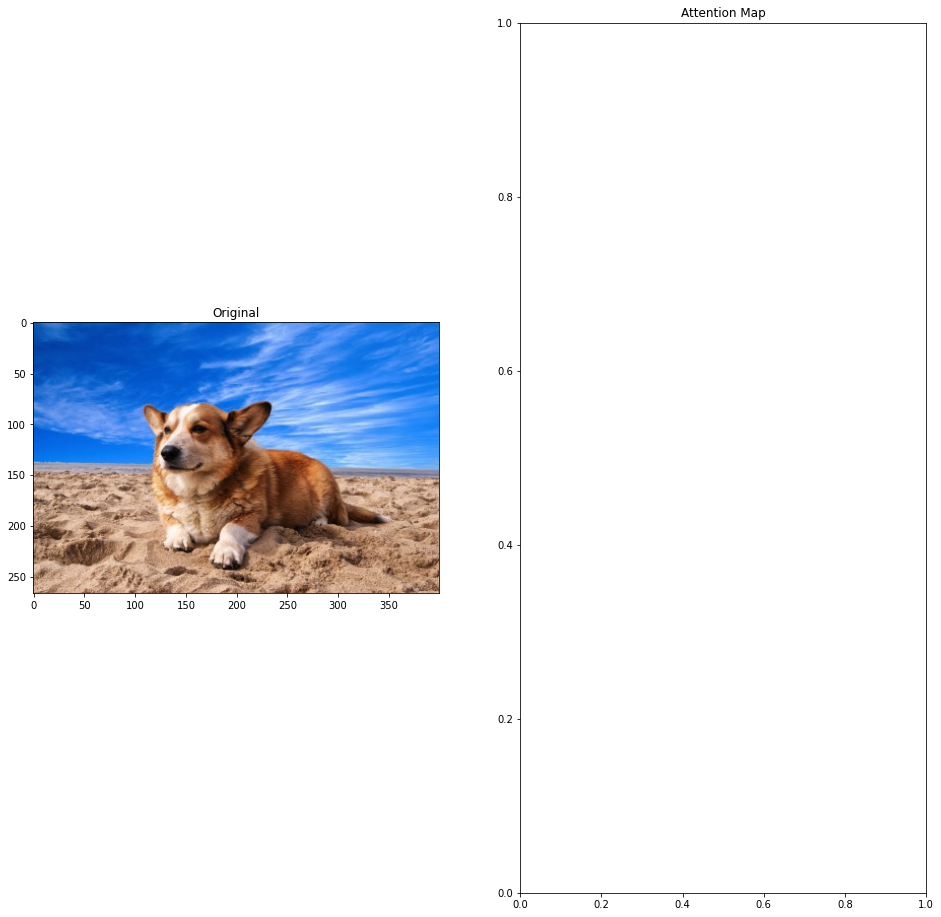

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')